# Neiss Datasets

In [91]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df_list = []
for year in range(2014, 2024):
    path = f'./data/neiss{year}.tsv'
    print(path, '...', sep='')
    try:
        df_list.append(pd.read_csv(path, sep='\t'))
    except UnicodeDecodeError:
        print('Exception Caught')
        print(path, '...', sep='')
        print(len(pd.read_csv(path, sep='\t', encoding='ISO-8859-1')))
        df_list.append(pd.read_csv(path, sep='\t', encoding='ISO-8859-1'))
df = pd.concat(df_list, axis=0, ignore_index=True)

./data/neiss2014.tsv...
./data/neiss2015.tsv...
./data/neiss2016.tsv...
./data/neiss2017.tsv...
Exception Caught
./data/neiss2017.tsv...


/var/folders/sz/hbk1460n5wdbf8wpmtyd24sc0000gn/T/ipykernel_98744/927198845.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  print(len(pd.read_csv(path, sep='\t', encoding='ISO-8859-1')))


386907


/var/folders/sz/hbk1460n5wdbf8wpmtyd24sc0000gn/T/ipykernel_98744/927198845.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(path, sep='\t', encoding='ISO-8859-1'))


./data/neiss2018.tsv...


/var/folders/sz/hbk1460n5wdbf8wpmtyd24sc0000gn/T/ipykernel_98744/927198845.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(path, sep='\t'))


./data/neiss2019.tsv...


/var/folders/sz/hbk1460n5wdbf8wpmtyd24sc0000gn/T/ipykernel_98744/927198845.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(path, sep='\t'))


./data/neiss2020.tsv...
./data/neiss2021.tsv...


/var/folders/sz/hbk1460n5wdbf8wpmtyd24sc0000gn/T/ipykernel_98744/927198845.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(path, sep='\t'))


./data/neiss2022.tsv...
./data/neiss2023.tsv...


/var/folders/sz/hbk1460n5wdbf8wpmtyd24sc0000gn/T/ipykernel_98744/927198845.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(path, sep='\t'))


In [5]:
# Drop records with missing Narrative_1 data
df.drop(df[df['Narrative_1'].isnull()].index, axis=0, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3520522 entries, 0 to 3520529
Data columns (total 25 columns):
 #   Column             Dtype  
---  ------             -----  
 0   CPSC_Case_Number   object 
 1   Treatment_Date     object 
 2   Age                int64  
 3   Sex                float64
 4   Race               float64
 5   Other_Race         object 
 6   Hispanic           float64
 7   Body_Part          float64
 8   Diagnosis          float64
 9   Other_Diagnosis    object 
 10  Body_Part_2        float64
 11  Diagnosis_2        float64
 12  Other_Diagnosis_2  object 
 13  Disposition        float64
 14  Location           float64
 15  Fire_Involvement   float64
 16  Product_1          float64
 17  Product_2          float64
 18  Product_3          float64
 19  Alcohol            float64
 20  Drug               float64
 21  Narrative_1        object 
 22  Stratum            object 
 23  PSU                float64
 24  Weight             float64
dtypes: float64(17), int64(1

In [7]:
from transformers import BertTokenizer
from datasets import Dataset

/opt/anaconda3/envs/hf_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Fine Tuning Distil-BERT

In [93]:
from datasets import Dataset, ClassLabel, Features, Value
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from evaluate import load
import torch.nn.functional as F

from peft import LoraConfig, get_peft_model

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Plan to Strengthen the Model
> The current model was trained on an initial set of 237 human-labeled samples. It achieved an overall accuracy of 80.0%, with a precision of 83.3% on samples labeled as pedestrian injuries. The following steps will be implemented to further strengthen and refine the model.

1. Combine labeled data: Merge the original 237 labeled samples with the 100 newly labeled ones, resulting in a training/validation set of 337 examples.
1. Create a holdout evaluation set by stratifying 150 samples:
    * 50 containing the word or some variation of the word “pedestrian”
    * 50 containing “struck by” or “hit by” 
    * 50 containing both

    These samples will not be among the 337 samples used for training and will be manually labeled and reserved exclusively for final evaluation.
3. Train the model: Perform a new train/validation split and fine-tune the model accordingly.
4. Generate predictions using softmax probabilities instead of argmax. Then proceed with one of two approaches:
* **4.1. Keep existing model and tune threshold:** 
    * Classify a narrative as a pedestrian injury only if the model assigns a probability ≥ 80% (or another calibrated value). Evaluate this model on the holdout set to measure precision and overall performance.
* **4.2. Add additional data based on softmax probablities:**
    * Auto-label: Add all of the data where the model was ≥ 90% and ≤ 10% sure to expand the dataset.
    * Manual label: Add ~50 borderline predictions (45–55% confidence) to refine the model near the decision boundary.
    * Retrain the model with the expanded dataset and evaluate on the same holdout set.
5. Compare results from steps 4.1 and 4.2 and select the version that delivers the best precision and overall performance as the final model.

## 1. Combine labeled data to make the train/validation set

In [16]:
labeled_sample = pd.read_csv('ped_accident_labels.csv')
performance_df = pd.read_csv('performance_df.csv')

In [17]:
# Combining the two, only keeping the narrative and the human label
train_validation = pd.concat(
    [labeled_sample[['Narrative_1', 'Pedestrian Label']].rename(columns={'Pedestrian Label': 'Human Label'}),
     performance_df[['Narrative_1', 'Human Label']]],
    axis=0)

## 2. Create Holdout Set

In [18]:
# Step 1: Filter narratives that contain relevant keywords related to pedestrian activity or motor vehicle involvement
search_words = [
    "walking", "walk", "jogging", "jog", "running", "run", "on foot", "bystander",
    "standing", "biking", "bike", "roller skating", "roller skates", "skateboarding",
    "skateboard", "scootering", "scooter", "pedestr", "pedst", "struck by", "hit by"
]

filtered_df = df[df['Narrative_1'].str.contains('|'.join(search_words), case=False, na=False)]

# ~470,000 samples contain at least one keyword (~6.25 hours to run locally)
len(filtered_df)

471460

In [19]:
# Step 2: Filter further by location codes of interest (e.g., street or highway)
filtered_df = filtered_df[filtered_df['Location'].isin([4, 5])]

# ~96,000 samples remain (~76.5 minutes to run locally)
print(len(filtered_df))

96128


In [20]:
# Step 3: Focus on narratives that explicitly mention "pedestrian", "struck by", or "hit by"
filtered_df = filtered_df[filtered_df['Narrative_1'].str.contains('|'.join(["pedestr", "pedst", "struck by", "hit by"]), case=False, na=False)]

# ~20,000 high-priority samples (~15 minutes to run locally)
print(len(filtered_df))

19489


This subset of ~20,000 samples contains location-relevant narratives with keywords most likely to reflect pedestrian injuries involving motor vehicles. This will serve as the primary dataset for local experimentation. In future iterations, model weights may be exported and applied at scale on larger datasets using cloud resources.

In [21]:
# Excluding data that out model will be trained on
filtered_df = filtered_df[~filtered_df['Narrative_1'].isin(train_validation['Narrative_1'])]

# There are 19,226 samples that are not in our train/validation set
# NOTE: Some data in our train_validation set are not in our original filtered_df since the location codes outside of 4 and 5 were not excluded initially
len(filtered_df)

19226

In [22]:
# Mask that contains all of the narratives containing pedestrian
pedestrian_mask = filtered_df['Narrative_1'].str.contains('pedst|pedestr', case=False, na=False)
# Mask containing all of the narratives containing struck by/hit by
struck_hit_mask = filtered_df['Narrative_1'].str.contains('struck by|hit by', case=False, na=False)

# df containing 50 "pedestrian" samples that don't contain "struck/hit" by
group_a = filtered_df[pedestrian_mask & ~struck_hit_mask].sample(50, random_state=42)

# df containing 50 "struck/hit by" samples that dont contain "pedestrian"
group_b = filtered_df[struck_hit_mask & ~pedestrian_mask].sample(50, random_state=42)

# df containing 50 samples where both "pedestrian" and "struck/hit by" are present in the narrative
group_c = filtered_df[struck_hit_mask & pedestrian_mask].sample(50, random_state=42)

# Creating flags to test the models performance among each group
group_a['group'] = 'group_a'
group_b['group'] = 'group_b'
group_c['group'] = 'group_c'

# Holdout set containing all three groups
holdout = pd.concat([group_a, group_b, group_c], axis=0)

In [23]:
holdout.head()

,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Other_Race,Hispanic,Body_Part,Diagnosis,Other_Diagnosis,Body_Part_2,Diagnosis_2,Other_Diagnosis_2,Disposition,Location,Fire_Involvement,Product_1,Product_2,Product_3,Alcohol,Drug,Narrative_1,Stratum,PSU,Weight,group
1373638,170957638,09/24/2017,52,2.0,0.0,NaN,NaN,75.0,62.0,NaN,NaN,NaN,NaN,1.0,4.0,0.0,5040.0,0.0,0.0,NaN,NaN,52YF HELM'D BICYCLIST CRASHED INTO PEDESTRIAN&...,V,21.0,16.1828,group_a
2870136,220159454,01/25/2022,24,2.0,4.0,NaN,2.0,37.0,64.0,NaN,NaN,NaN,NaN,1.0,4.0,0.0,5040.0,0.0,0.0,0.0,0.0,"24 YOF IN MVA , PEDESTRIAN STRUCK AND INJ LEG ...",V,38.0,17.2223,group_a
3007698,220705908,06/09/2022,12,1.0,0.0,NaN,0.0,75.0,52.0,NaN,NaN,NaN,NaN,4.0,4.0,0.0,5040.0,0.0,0.0,0.0,0.0,12YOM BROUGHT IN BY AMBULANCE AFTER A PEDESTRI...,C,37.0,6.6676,group_a
703697,151238381,11/18/2015,40,1.0,2.0,NaN,NaN,36.0,57.0,NaN,NaN,NaN,NaN,1.0,4.0,0.0,5040.0,0.0,0.0,NaN,NaN,40 YOM DX DISPLACED FX OF LT TIBIAL SPINE - S/...,V,57.0,16.5650,group_a
849328,160538697,05/12/2016,25,2.0,2.0,NaN,NaN,81.0,71.0,LEG/MOUTH PAIN,NaN,NaN,NaN,1.0,4.0,0.0,5040.0,0.0,0.0,NaN,NaN,25 YOF DX LEG/MOUTH PAIN - S/P PT PEDESTRIAN S...,V,57.0,14.6504,group_a


## 3. Train the model

In [24]:
features = Features({
    'text': Value('string'),
    'labels': ClassLabel(names=["Not Pedestrian", "Pedestrian"])
})

dataset = Dataset.from_pandas(
    df=train_validation.rename(columns={'Narrative_1':'text', 'Human Label': 'labels'}).reset_index(drop=True),
    features=features
)

dataset = dataset.train_test_split(test_size=0.2, seed=42, stratify_by_column='labels')

In [25]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 269
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 68
    })
})

In [26]:
# Initializing tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# defining the tokenization function
def tokenize(sample):
    return tokenizer(
        sample['text'],
        # padding='max_length',
        truncation=True
    )
    
results = dataset.map(tokenize, batched=True)

Map: 100%|██████████| 68/68 [00:00<00:00, 6869.95 examples/s]


In [27]:
id2label = {0: "Not Pedestrian", 1: "Pedestrian"}
label2id = {"Not Pedestrian":0, "Pedestrian": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels = 2,
    id2label = id2label,
    label2id = label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
peft_config = LoraConfig(
    task_type='SEQ_CLS', # Defining the classification type to be Sequence Classification
    r=8, # Lora attention dimension (intrinsic rank of the low-rank matricies)
    lora_alpha=32, # Alpha Parameter for Lora scaling (like the learning rate)
    lora_dropout=0.1, # The dropout probability for Lora layers
    target_modules=['q_lin', 'k_lin', 'v_lin', 'ffn.lin1', 'ffn.lin2'] # We will start by allowing the query, key, and value linear layers to be modified by the model
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 1,181,954 || all params: 68,136,964 || trainable%: 1.7347


In [29]:
# Load evaluation metrics
accuracy = load("accuracy")
precision = load("precision")
recall = load("recall")
f1_score = load("f1")

# Define a metric function for evaluation
def compute_metrics(p):
    pred = np.argmax(p.predictions, axis=1)
    labels = p.label_ids

    return {
        "accuracy": accuracy.compute(predictions=pred, references=labels)['accuracy'],
        "precision": precision.compute(predictions=pred, references=labels, average='binary')['precision'],
        "recall": recall.compute(predictions=pred, references=labels, average='binary')['recall'],
        "f1": f1_score.compute(predictions=pred, references=labels, average='binary')['f1'],
    }

In [30]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Hyperparameters
lr = 0.00005 # Size of optimization step
batch_size = 8 # number of examples processed per optimization step
num_epochs = 10 # number of times the model runs through training data
weight_decay = 0.1

# Defining the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True, 
    save_total_limit=4,
    report_to='tensorboard',
    do_eval=True, 
    logging_strategy='epoch'
)

In [31]:
trainer = Trainer(
    model=model, # our peft model
    args=training_args, # hyperparameters
    train_dataset=results['train'], # training data
    eval_dataset=results['test'], # validation data
    tokenizer=tokenizer, # The narratives from the training and testing sets are already pre-tokenized. Passing the tokenizer here is primarily used for decoding predictions
    data_collator=data_collator,
    compute_metrics=compute_metrics # Runs on HuggingFace's EvalPrediction object (see compute metrics notes for how this works)
)

/var/folders/sz/hbk1460n5wdbf8wpmtyd24sc0000gn/T/ipykernel_98744/2352482910.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [32]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.695300,0.677910,0.544118,0.544118,1.000000,0.704762
2,0.680600,0.657357,0.573529,0.560606,1.000000,0.718447
3,0.651000,0.599204,0.750000,0.700000,0.945946,0.804598
4,0.594600,0.503210,0.808824,0.785714,0.891892,0.835443
5,0.504200,0.454362,0.764706,0.733333,0.891892,0.804878
6,0.449400,0.424157,0.808824,0.785714,0.891892,0.835443
7,0.437200,0.402123,0.823529,0.804878,0.891892,0.846154
8,0.406600,0.407257,0.794118,0.767442,0.891892,0.825000
9,0.380100,0.416829,0.808824,0.772727,0.918919,0.839506
10,0.361300,0.414212,0.808824,0.772727,0.918919,0.839506


TrainOutput(global_step=340, training_loss=0.5160315429463106, metrics={'train_runtime': 140.9162, 'train_samples_per_second': 19.089, 'train_steps_per_second': 2.413, 'total_flos': 57094857486480.0, 'train_loss': 0.5160315429463106, 'epoch': 10.0})

## 4. Generate predictions using softmax as opposed to argmax

In [50]:
model.to('mps')

print('Classifying narratives containing pedestrian')
print('--------------------------------------------')

classifications = []
for narrative in holdout['Narrative_1']:
    # Tokenize text
    inputs = tokenizer.encode(narrative, return_tensors='pt').to('mps')
    # compute logits
    logits = model(inputs).logits
    # Convert logits to label
    predictions = F.softmax(logits, dim=1)[0,1].item() # Takes the 0th batch and the 1st predicted probability (pedestrian) from the tensor
    
    classifications.append(predictions)

Classifying narratives containing pedestrian
--------------------------------------------


In [51]:
holdout['Pedestrian Probability'] = classifications

In [54]:
holdout.to_clipboard()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [57]:
holdout_labeled = pd.read_csv('holdout_labeled.csv', index_col=0)

In [61]:
from sklearn.metrics import precision_recall_curve

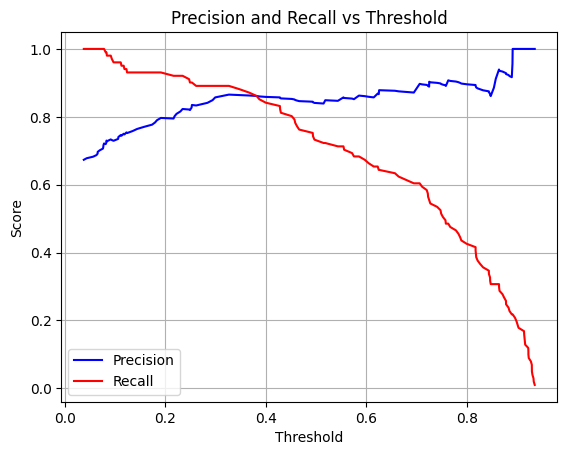

In [63]:
precision, recall, thresholds = precision_recall_curve(holdout_labeled['Human Label'], holdout_labeled['Pedestrian Probability'])
# Plot precision and recall vs threshold
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="red")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)

In [64]:
holdout_labeled['proba_50'] = (holdout_labeled['Pedestrian Probability'] > 0.5).astype(int)
holdout_labeled['proba_60'] = (holdout_labeled['Pedestrian Probability'] > 0.6).astype(int)
holdout_labeled['proba_80'] = (holdout_labeled['Pedestrian Probability'] > 0.8).astype(int)

In [71]:
def report(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    cm_display = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
    cm_display.plot(cmap='YlGnBu')
    plt.show()

              precision    recall  f1-score   support

           0       0.56      0.71      0.62        49
           1       0.84      0.72      0.78       101

    accuracy                           0.72       150
   macro avg       0.70      0.72      0.70       150
weighted avg       0.75      0.72      0.73       150



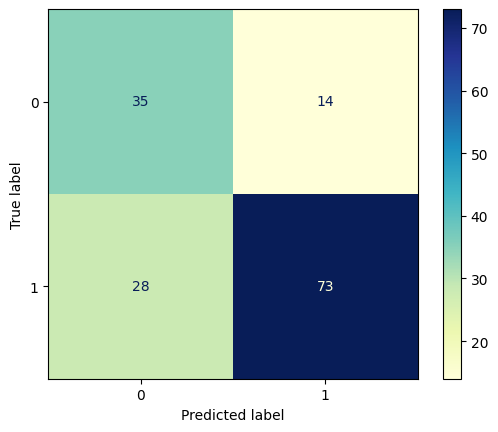

In [72]:
report(holdout_labeled['Human Label'], holdout_labeled['proba_50'])

              precision    recall  f1-score   support

           0       0.53      0.78      0.63        49
           1       0.86      0.66      0.75       101

    accuracy                           0.70       150
   macro avg       0.69      0.72      0.69       150
weighted avg       0.75      0.70      0.71       150



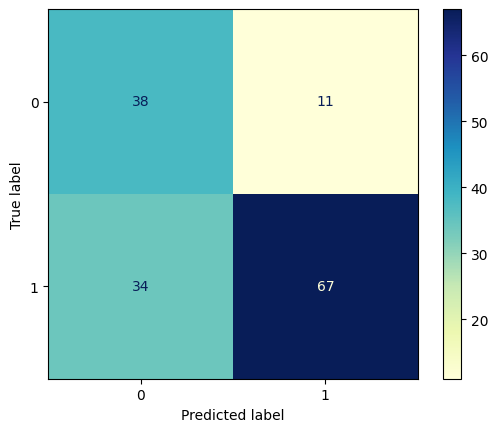

In [73]:
report(holdout_labeled['Human Label'], holdout_labeled['proba_60'])

              precision    recall  f1-score   support

           0       0.43      0.90      0.58        49
           1       0.89      0.42      0.57       101

    accuracy                           0.57       150
   macro avg       0.66      0.66      0.57       150
weighted avg       0.74      0.57      0.57       150



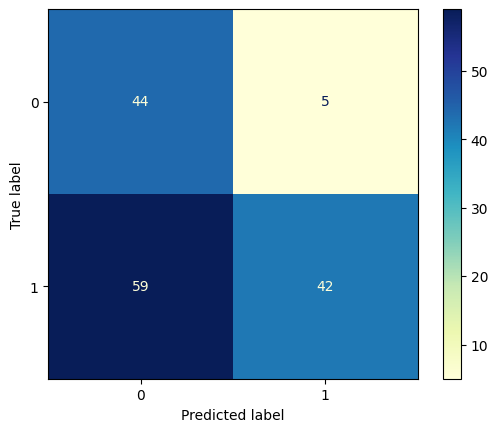

In [74]:
report(holdout_labeled['Human Label'], holdout_labeled['proba_80'])

group_a
              precision    recall  f1-score   support

           0       0.82      0.79      0.81        29
           1       0.73      0.76      0.74        21

    accuracy                           0.78        50
   macro avg       0.77      0.78      0.78        50
weighted avg       0.78      0.78      0.78        50



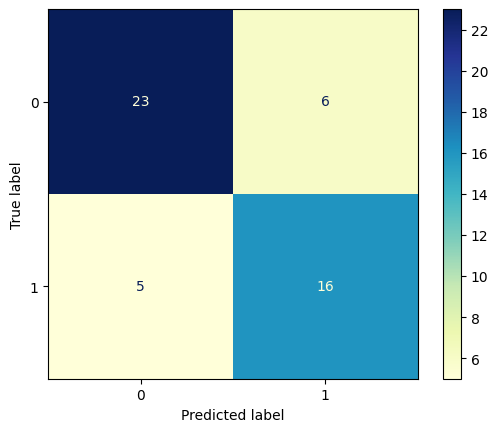

group_b
              precision    recall  f1-score   support

           0       0.28      0.62      0.38         8
           1       0.91      0.69      0.78        42

    accuracy                           0.68        50
   macro avg       0.59      0.66      0.58        50
weighted avg       0.81      0.68      0.72        50



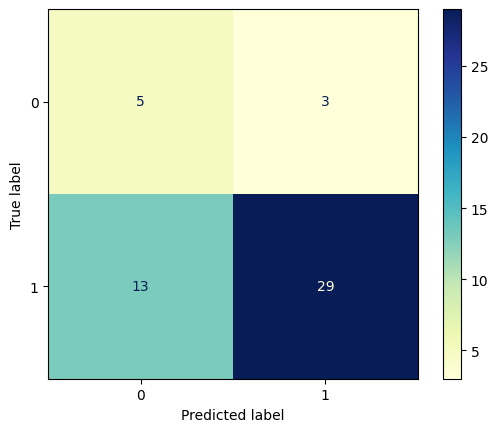

group_c
              precision    recall  f1-score   support

           0       0.41      0.58      0.48        12
           1       0.85      0.74      0.79        38

    accuracy                           0.70        50
   macro avg       0.63      0.66      0.64        50
weighted avg       0.74      0.70      0.72        50



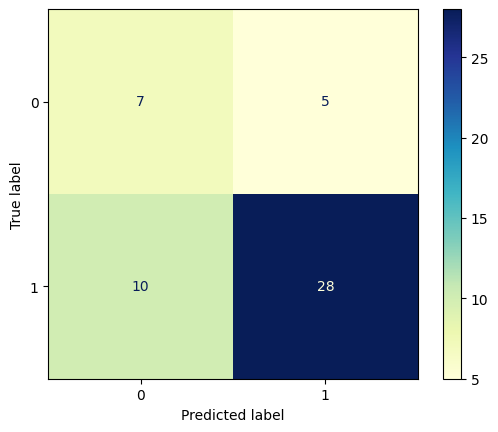

In [75]:
for group in holdout_labeled['group'].unique():
    print(group)
    report(holdout_labeled[holdout_labeled['group']==group]['Human Label'], holdout_labeled[holdout_labeled['group']==group]['proba_50'])

## 4.2 Add additional data based on softmax probabilities

In [80]:
def auto_label(proba):
    if proba > 0.9:
        return 'pedest_likely'
    if proba < 0.1:
        return 'not_pedest_likely'
    if 0.45 < proba < 0.55:
        return 'hand_label'
    else:
        return 'n/a'

In [83]:
holdout_labeled['auto_label'] = holdout_labeled['Pedestrian Probability'].apply(auto_label)

In [89]:
holdout_labeled[(holdout_labeled['auto_label'] == 'not_pedest_likely') & holdout_labeled['Human Label']==1]['Narrative_1'].values

array(['20YOF PRESENTED TO ED C/O PEDESTRAIN STRUCK, PT STATED SHE WAS STRUCK BY A CAR WHILE RIDING SCOOTER. DX; ANKLE PAIN, MVC',
       '22YOM WAS PEDESTRIAN STRUCK BY MOTORIZED SCOOTER DX: CALF ABRASION, BACK PAIN',
       "58YOF PRESENTS TO THE ED FOLLOWING PEDESTRIAN VS. AUTO ACCIDENT PTA. PT STATES SHE WAS RIDING HER BICYCLE WHEN SHE WAS STRUCK BY A VEHICLE TRAVELING @25-30 MPH. SHE STATES SHE FELL FORWARDS OVER THE HANDLEBARS OF HER BICYCLE, STRUCK HER MOUTH AGAINST THE HANDLEBARS, AND WAS UNHELMETED. DX: NECK PAIN, HIP PAIN'",
       '56 YOM DX FACE/HAND ABRASION - S/P PT PEDESTRIAN STRUCK BY CAR WHILERIDING SCOOTER PTA.'],
      dtype=object)

In [90]:
holdout_labeled[(holdout_labeled['auto_label'] == 'hand_label')]['Narrative_1'].values

array(['69YOM WAS RIDING HIS BICYCLE WHEN HE WAS HIT BY A CAR DX: CONTUSION OF RIGHT LOWER LEG',
       '47 YO M PT WAS RIDING BICYCLE WHEN STRUCK BY A CAR GOING 50MPH PT FLEWUP ON CAR.MULTIPLE FRACTURES NECKPAIN,LOWER LEG DX FRAC NECK ADMIT',
       '9 YOM WAS RIDING HIS BIKE WHEN HE WAS HIT BY A CAR AND KNOCKED OFF HISBIKE AND SCRAPED HIS KNEE/KNEE CONTUSION',
       '16YOM WAS RIDING HIS BIKE AND CROSSING AN INTERSECTION WHEN HE WAS STRUCK BY AN SUV THAT WAS TURNING. HE FLIPPED OFF THE BICYCLE BUT DOES NOT REMEMBER HOW HE LANDED. C/O LEFT SHOULDER PAIN AND POPPING IN HIS SHOULDER. ABRASIONS NOTED TO LEFT FOREHEAD, RIGHT ELBOW, LEFT FOREARM, LEFT WRIST, LEFT KNEE, AND RIGHT LEG DX: SHOULDER INJURY; MVC; ABRASIONS',
       '14 YOM RIDING BIKE UNHELMETED HIT BY A CAR @ 30-45 MPH FELL TO GROUND BRIEF LOC DX CONCUSSION',
       '22 YOF WAS WALKING HER BICYCLE ACROSS A CROSSWALK WHEN SHE WAS HIT BYA CAR. DX: CONTUSION, RT THIGH, ABRASIONS TO R ELBOW & BACK',
       '29YOM WITH RLE PAIN AF